## Draft of UCT for active learning strategy using clusters
* Refactor UCT to use only X (known) and playout faster
* Add scorer using clusters
* Test 
* Add UCT game selecting from clusters and then sampling

In [1]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.insert(0, "/lhome/home/jastrzebski/mlls2015/")
sys.path.insert(0, "..")
import misc
from collections import defaultdict
import copy, math, sys
import numpy as np
from collections import namedtuple
import copy
from sklearn.utils import check_random_state
import sys
sys.path.append("..")
from misc.config import *
from misc.utils import *
config_log_to_file("uct_circle_and_cross.log", level=logging.INFO)
logger = logging.getLogger("uct_circle_and_cross")
import time, random
from functools import partial
import models
from sklearn.cluster import KMeans
import seaborn
from models.uct import *
import matplotlib.pylab as plt
%matplotlib inline
import sklearn
from alpy2.uct_strategy import *
from sklearn.cluster import KMeans
from sklearn.linear_model import Perceptron
from alpy2.utils import mask_unknowns, unmasked_indices, masked_indices
from alpy2.strategy import *
from sklearn.metrics import pairwise_distances
from copy import deepcopy

/Users/kudkudak/.virtualenvs/go-deep/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def normalized_euclidean_pairwise_distances(X):
    """ d(i, j) = ||xi - xj||/max(||xk - xl||)"""
    D = pairwise_distances(X, metric="euclidean")
    return D / D.max()

def exponential_pairwise_distances(x1, x2):
    """ d(i, j) = exp(-||xi - xj||)"""
    D = pairwise_distances(X, metric="euclidean")
    return 1 - np.exp(-D)

# Data generation

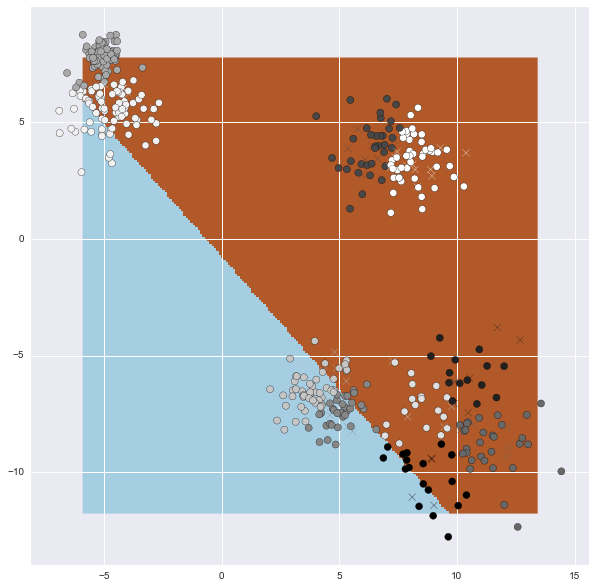

In [3]:
def gauss_sample(N, K, D=2):
    mean = np.random.uniform(-10,10, size=(N,D))
    dev = np.random.uniform(0.1, 2, size=(N,))
    size = np.random.uniform(0.5*K, 1.5*K, size=(N,))
    X = []
    for m,d,s in zip(mean, dev,size):
        X.append(np.random.normal(m, d, size=(K,D)))
    return np.vstack(X)

### Sample some data from multivariate gauss distribution ###
X = gauss_sample(5, 100, 2)
m = KMeans(n_clusters=10).fit_predict(X)
hyperplane = np.random.uniform(0,1,size=(3,))
y = np.array([hyperplane[0:2].dot(p.reshape(-1,1)) + hyperplane[2] >= 0 for p in X]).reshape(-1)
samples = np.random.choice(range(X.shape[0]), 100)
y = mask_unknowns(y, range(len(y)))
# Unmask part of data
y[samples] = y.data[samples] 

### Plot imperfect Perceptron and additionally coloured clusters of data ###
# 'x' are 1s and 'o' are 0s

m = KMeans(n_clusters=10).fit_predict(X)
model = Perceptron().fit(X[samples], y[samples]) 
plt.figure(figsize=(10,10))


# Plot the decision boundary. For that, we will assign a color to each
h = 0.1
x_min, x_max = X[:, 0].min() + 1, X[:, 0].max() - 1
y_min, y_max = X[:, 1].min() + 1, X[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# True example labels
for mark, cls in zip(['o','x'], [0,1]):
    plt.scatter(X[y==cls, 0], X[y==cls, 1],s=50,c = m[y==cls], marker=mark)

In [30]:
def uqgb_strategy(game, N=2000, solver="iterative"):
    state = {"ids": []}
    if solver == "iterative":
        for i in range(batch_size):
            uct = UCT(N=N, game=game, policy=ucb_policy, progressive_widening=False)
            uct.partial_fit(state, N=N)
            state = uct.best_path_[1].state # Next after root
            assert len(state['ids'])== i+1
    elif solver == "single":
        uct = UCT(N=N*game.batch_size, game=game, policy=ucb_policy, progressive_widening=False)
        uct.fit(state)
        state = uct.playout(uct.best_path_[-1].state, N=N)
        assert len(state['ids']) == game.batch_size
    else:
        raise RuntimeError("Not implemented solver")
    return state['ids']

# Using UCT for optimization in cluster case

In [28]:
distance_cache = normalized_euclidean_pairwise_distances(X)
model = Perceptron().fit(X[unmasked_indices(y)], y[unmasked_indices(y)])
batch_size = 20
K = 40
c = 0.3
rng = 777
picking_function = "max"

X_unknown = X[masked_indices(y)]
clustering = KMeans(n_clusters=K).fit_predict(X_unknown)
# Slightly ugly, but fine for me
X_clustered = [np.where(clustering==id)[0].tolist() for id in set(clustering.tolist())]

base_strategy = UncertaintySampling()
scorer = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size, \
                                clustering=clustering)



game_cluster = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer, batch_size=batch_size, \
                               element_picking_function=picking_function)

In [29]:
strategy = QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=10)
qgb_solution = strategy(X, y, rng=np.random.RandomState(777), 
                               model=model, batch_size=20, return_score=False)
uqgb_solution = uqgb_strategy(game=game_cluster, N=1000, solver="single")
assert len(uqgb_solution) == batch_size
print "QGB (n_tries=1) ", scorer.score(qgb_solution, remap=False)
print "UCT: ", scorer.score(uqgb_solution)

QGB (n_tries=1)  0.804408728262
UCT:  0.67600061807


# Using UCT for optimization

In [ ]:
distance_cache = normalized_euclidean_pairwise_distances(X)
model = Perceptron().fit(X[unmasked_indices(y)], y[unmasked_indices(y)])
batch_size = 20
c = 0.3
rng = 777
base_strategy = UncertaintySampling()
scorer = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size)
game = SetFunctionOptimizerGame(rng=777, X=X[masked_indices(y)], scorer=scorer, batch_size=batch_size)

In [ ]:
strategy = QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=2)
qgb_solution = strategy(X, y, rng=np.random.RandomState(777), 
                               model=model, batch_size=20, return_score=False)
def uqgb_strategy(N=2000):
    state = {"ids": []}
    for i in range(batch_size):
        uct = UCT(N=N, game=game, policy=ucb_policy, progressive_widening=False)
        uct.partial_fit(state, N=N)
        state = uct.best_path_[1].state # Next after root
        assert len(state['ids'])== i+1
    return state['ids']

uqgb_solution = uqgb_strategy(N=10000)
assert len(uqgb_solution) == batch_size
print "QGB (n_tries=1) ", scorer.score(qgb_solution, remap=False)
print "UCT: ", scorer.score(uqgb_solution)

# Experiments

In [ ]:
scores = []
Ns = []
for N in np.linspace(50, 500, 5):
    Ns.append(N)
    scores.append(scorer.score(uqgb_strategy(N=int(N))))
    print scores, N

In [ ]:
scores_cluster = []
for N in np.linspace(50, 500, 5):
    Ns.append(N)
    scores_cluster.append(scorer.score(uqgb_strategy(game=game_cluster, N=int(N))))
    print scores, N

In [ ]:
plt.plot(scores, label="UCT QGB score")
plt.plot(scores_cluster, label="UCT-40_cluster_max QGB score")
plt.xlabel("N")
plt.ylabel("score")
plt.plot([scorer.score(qgb_solution, remap=False) for _ in range(len(scores))], label="QGB score")
plt.legend()

# Experiment with actual data